### Import packages

In [1]:
!pip install brian2
!pip install ipympl
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have num

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive 
drive.mount('/content/drive')
import brian2 as b2
from brian2.monitors.spikemonitor import SpikeMonitor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score
import pandas as pd
import seaborn as sn
import math
from random import shuffle
from collections import Counter
import os
import h5py
# import ipdb # ipdb.set_trace() ### breakpoint
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget
#%matplotlib inline
b2.core.preferences.prefs.codegen.target = "numpy"

b2.defaultclock.dt = 0.1 * b2.ms

Mounted at /content/drive


### Parameters

In [2]:
ni = 16*16
n_classes = 10
nn = 10

min_rate = 0
max_rate = 300

file_path_weights = 'drive/My Drive/Colab Notebooks/investigate_myelin_rule/usps/synapses_e_weights.npy'

In [15]:
n_train = 20 # max 5420 # full 7291
n_test = 200 # max 1470 # full 2007

g_amp = 2.2 / ni # 2.8
tau_const = 20 # 100 # 30

train_period = 350 * b2.ms 
time_relax = 150 * b2.ms

In [4]:
v_initial = -65 * b2.mV + 10*np.random.rand(1,nn) * b2.mV
w_initial = g_amp/4 + 0.1*g_amp*np.random.rand(1,nn*ni)
#w_initial = 'rand() * g_amp'

### Functions

In [5]:
def show_plots_v(e_state_mon, e_spike_mon, ind_input):
    n_plot = len(ind_input)
    # plot the evolution of membrane potential 
    plt.figure(figsize = (16, 8))
    for ind, n in enumerate(ind_input):
        if (ind==0): sp1 = plt.subplot(n_plot,1,1) # make equal scales
        else: plt.subplot(n_plot,1,ind+1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.v[n]/b2.mV, label='$v$')
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.vt_n[n]/b2.mV , label='$v_T$')
        # for t in i_spike_mon.t:
        #     plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
        for t in e_spike_mon.spike_trains()[n]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={n}")

def show_plots_gn(e_state_mon, e_spike_mon, ind_input):
    n_plot = len(ind_input)
    # plot the evolution of g_n 
    plt.figure(figsize = (16, 8))
    for ind, n in enumerate(ind_input):
        if (ind==0): sp1 = plt.subplot(n_plot,1,1) # make equal scales
        else: plt.subplot(n_plot,1,ind+1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.g_n[n] , label='$g_n$')
        # for t in i_spike_mon.t:
        #     plt.axvline(t/b2.ms, ls='--', c='C1', lw=1) # orange == input
        for t in e_spike_mon.spike_trains()[n]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={n}")

def plot_v_g_n(e_state_mon, e_spike_mon, ind_input):
    n_plot = len(ind_input)
    plt.figure(figsize = (16, 8))
    for ind, n in enumerate(ind_input):
        if (ind==0): sp1 = plt.subplot(n_plot,1,1) # make equal scales
        else: plt.subplot(n_plot,1,ind+1, sharex=sp1, sharey=sp1)
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.v[ind]/b2.mV, label='$v$')
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.vt_n[ind]/b2.mV , label='$v_T$')
        for t in e_spike_mon.spike_trains()[ind]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        plt.legend()
        plt.grid()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={ind}")
    for ind in ind_input:
        plt.figure(figsize = (8, 2))
        plt.plot(e_state_mon.t/b2.ms, e_state_mon.g_n[ind] , label='$g_n$')
        for t in e_spike_mon.spike_trains()[ind]:
            plt.axvline(t/b2.ms, ls='--', c='C2', lw=1) # green == main
        plt.legend()
        plt.xlabel("$t$, ms")
        plt.ylabel(f"n={ind}")

def show_plots_w(i_spike_mon, e_spike_mon, s_state_mon, ind_input, ind_s):
    for s in range(len(ind_s)):
        plt.figure(figsize=(16,8))
        plt.plot(s_state_mon.t/b2.second, s_state_mon.w[ind_s[s] * nn + ind_input] , label=f'w of n={ind_input} s={ind_s[s]}')
        for t in i_spike_mon.spike_trains()[ind_s[s]]:
            plt.axvline(t/b2.second, ls='--', c='C1', lw=0.5) # orange == pre
        for t in e_spike_mon.spike_trains()[ind_input]:
            plt.axvline(t/b2.second, ls='--', c='C2', lw=0.5) # green == post
        plt.legend()
        plt.xlabel("t, seconds")

def plot_steps_w(current_w, ind_input, step_range):
    for m in step_range:
        plt.figure(figsize = (8, 2))
        for ind in range(len(ind_input)):
            plt.subplot(1,len(ind_input),ind+1)
            plt.imshow(current_w[m][ind_input[ind]].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
            plt.title(f"n={ind_input[ind]} weights")
            plt.colorbar()

def plot_final_w(final_w):
    for i in range(0, nn):
        plt.figure(figsize = (3, 2))
        plt.imshow(final_w[i].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
        plt.title(f"n={i} final weights")
        plt.colorbar()

def test_func(snn, rates_sample):
    test_mon = SpikeMonitor(snn.group_n)
    snn.net.add(test_mon)
    snn.input_group.rates = rates_sample * b2.Hz
    snn.net.run(train_period)
    snn.input_group.rates = 0 * b2.Hz
    snn.net.run(time_relax)
    snn.net.remove(test_mon)
    return test_mon.count

def CreateClasses(snn, train_rates, labels, plot = None):
    if plot: 
        e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
        spike_mon = SpikeMonitor(snn.group_n)
        snn.net.add(e_state_mon, spike_mon)
    spike_num = np.zeros([n_classes, nn])
    classes_dic = {}
    n_samples = len(train_rates)
    for i in range(n_samples):
        spike_num[labels[i], :] += np.asarray(test_func(snn, train_rates[i]))
        if i % 10 == 0: print(f'Sample done: {i} / {n_samples}')
    for j in range(nn): 
        if np.sum(spike_num[:, j]) > 0.0: 
            classes_dic[j] = str(np.argmax(spike_num[:, j]))
        else: classes_dic[j] = "None"
    print(classes_dic)
    print(spike_num)
    if plot: 
        plot_v_g_n(e_state_mon, spike_mon)
        snn.net.remove(e_state_mon, spike_mon)
    return classes_dic

def predict(snn, test_rates, classes, plot = None):
    if plot:
        e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
        spike_mon = SpikeMonitor(snn.group_n)
        snn.net.add(e_state_mon, spike_mon)
    pred = []
    n_samples = len(test_rates)
    for ind, rates_sample in enumerate(test_rates):
        spike_num = np.asarray(test_func(snn, rates_sample))
        if np.sum(spike_num) > 0.0: 
            spiked_neurons, = np.where(spike_num > 0.0)
            spiked_neurons_preds = []
            for spiked_neuron in spiked_neurons:
                for _ in range(spike_num[spiked_neuron]):
                    spiked_neurons_preds.append(classes[spiked_neuron])
            counted = Counter(spiked_neurons_preds)
            pred += [max(counted, key=counted.get)]
        else: pred += ["None"] 
        if ind % 10 == 0: print(f'Sample done: {ind} / {n_samples}')
    if plot: 
        plot_v_g_n(e_state_mon, spike_mon)
        snn.net.remove(e_state_mon, spike_mon)
    return pred

def show_confusion_matrix(pred, labels):
    data = {'y_Actual': labels, 'y_Predicted': pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize = (10, 8))
    sn.heatmap(confusion_matrix, annot=True)

def show_wrong_pics(pred, labels, images):
    is_wrong_ind = np.array(pred) != np.array(labels)
    for j in range(len(is_wrong_ind)):
        if is_wrong_ind[j]:
            plt.figure(figsize = (4, 4))
            plt.imshow(images[j].reshape(round(np.sqrt(ni)), round(np.sqrt(ni))), cmap='gray')
            plt.xlabel(f"Actual: {labels[j]}, Predicted: {pred[j]}")
            plt.title(f"Wrong recognized pic: {j}")
            plt.colorbar()

def analyse(pred, labels):
    precision = accuracy_score(labels, pred)
    recall = recall_score(labels, pred, average='micro')
    F1_score = f1_score(labels, pred, average='micro')
    return precision, recall, F1_score 


### Data loading

Load the data

In [6]:
current_dir = os.getcwd()
with h5py.File('drive/My Drive/Colab Notebooks/investigate_myelin_rule/usps/usps.h5', 'r') as hf:
        train = hf.get('train')
        train_X = train.get('data')[:]
        train_Y = train.get('target')[:]
        test = hf.get('test')
        test_X = test.get('data')[:]
        test_Y = test.get('target')[:]

# for j in range(10):
#     print(len(train_Y[train_Y == j]))
# print('\n')
# for j in range(10):
#     print(len(test_Y[test_Y == j]))

Data balancing

In [7]:
n_samples_train = n_train//n_classes
x_ = []
y_ = []
for ind in range(n_classes):
    x_.append(train_X[train_Y==ind][:n_samples_train])
    y_.append(train_Y[train_Y==ind][:n_samples_train])
y_ = np.array(y_).reshape(-1)
x_ = np.array(x_).reshape(-1,256)
data = list(zip(x_,y_))
shuffle(data)
suffled_data = list(zip(*data))
train_images = np.array(list(suffled_data[0]))
train_labels = np.array(list(suffled_data[1]))

n_samples_test = n_test//n_classes
x_ = []
y_ = []
for ind in range(n_classes):
    x_.append(test_X[test_Y==ind][:n_samples_test])
    y_.append(test_Y[test_Y==ind][:n_samples_test])
y_ = np.array(y_).reshape(-1)
x_ = np.array(x_).reshape(-1,256)
data = list(zip(x_,y_))
shuffle(data)
suffled_data = list(zip(*data))
test_images = np.array(list(suffled_data[0]))
test_labels = np.array(list(suffled_data[1]))

# for ind in range(10):
#     print(len(train_labels[train_labels == ind]))
# print('\n')
# for ind in range(10):
#     print(len(test_labels[test_labels == ind]))


Plot the data

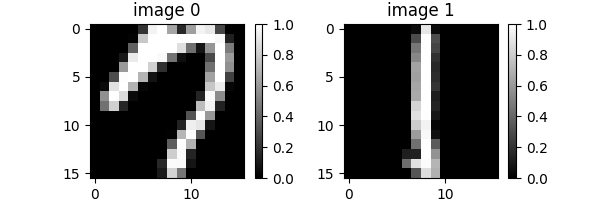

In [8]:
plt.figure(figsize = (6, 2))
plt.subplot(1,2,1)
plt.imshow(train_images[0].reshape(16,16), cmap='gray')
plt.title("image 0")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(train_images[7].reshape(16,16), cmap='gray')
plt.title("image 1")
plt.colorbar()

Encoding

In [9]:
train_rates = train_images*max_rate
test_rates = test_images*max_rate

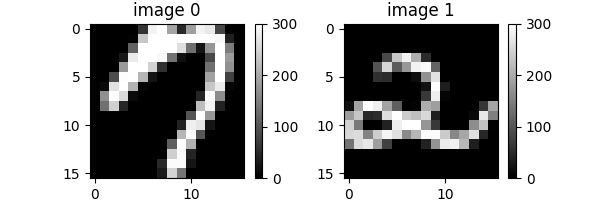

In [10]:
plt.figure(figsize = (6, 2))
plt.subplot(1,2,1)
plt.imshow(train_rates[0].reshape(16,16), cmap='gray')
plt.title("image 0")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(test_rates[7].reshape(16,16), cmap='gray')
plt.title("image 1")
plt.colorbar()

### Model SNN

In [16]:
class SNN:

    def __init__(self, nn, ni, v_initial, w_initial, train_mode=1):

        # Neurons
        model_n = '''
        dv/dt = ((E_rest_n - v) + g_n * (E_exc_n - v)) / tau_n: volt
        dg_n/dt = -g_n / tau_g_n : 1
        dvt_n/dt = (vt0_n-vt_n) / tc_vt_n * train_mode_n : volt
        tau_n : second
        tau_g_n : second
        E_rest_n : volt
        E_exc_n : volt
        vt0_n : volt
        tc_vt_n : second
        v_rest_n : volt
        v_reset_n : volt
        theta_n : volt
        train_mode_n : 1
        '''
        reset_n = '''
        v=v_reset_n
        vt_n += theta_n * train_mode_n
        '''
        self.group_n = b2.NeuronGroup(nn, model=model_n, threshold='v>vt_n', reset=reset_n, refractory=5 * b2.ms, method='euler')
        self.group_n.train_mode_n = train_mode
        self.group_n.tau_n = tau_const * b2.ms
        self.group_n.tau_g_n = 10 * b2.ms
        self.group_n.E_rest_n = -65 * b2.mV
        self.group_n.E_exc_n = 0 * b2.mV
        self.group_n.vt0_n = -52 * b2.mV
        self.group_n.vt_n = self.group_n.vt0_n
        self.group_n.tc_vt_n = 1e7 * b2.ms
        self.group_n.theta_n = 0.01 * b2.mV # 0.05
        self.group_n.v_rest_n = -65 * b2.mV
        self.group_n.v_reset_n = self.group_n.v_rest_n
        self.group_n.v = v_initial # self.group_n.v_rest_n

        # EXCISITORY synapses 
        model_e = '''
        dApre/dt = -Apre / taupre : 1 (event-driven)
        dApost/dt = -Apost / taupost : 1 (event-driven)
        w : 1
        gmax : 1
        taupre : second
        taupost : second
        dApre : 1
        dApost : 1
        train_mode_e : 1
        ''' 
        on_pre_e = '''
        g_n_post += w
        Apre += dApre
        w = clip(w + Apost * train_mode_e, 0, gmax)
        '''
        on_post_e = '''
        Apost += dApost
        w = clip(w + Apre * train_mode_e, 0, gmax)
        '''
        self.input_group = b2.PoissonGroup(ni, 0 * b2.Hz, name="input_group")

        self.synapses_e = b2.Synapses(self.input_group, self.group_n, model=model_e, on_pre=on_pre_e, on_post=on_post_e)
        self.synapses_e.connect()
        self.synapses_e.train_mode_e = train_mode
        self.synapses_e.gmax = g_amp
        self.synapses_e.taupre = 20 * b2.ms
        self.synapses_e.taupost = self.synapses_e.taupre
        self.synapses_e.dApre = 0.01 # 0.01 
        self.synapses_e.dApost = -self.synapses_e.dApre * self.synapses_e.taupre / self.synapses_e.taupost * 1.05
        self.synapses_e.dApost *= self.synapses_e.gmax
        self.synapses_e.dApre *= self.synapses_e.gmax
        if train_mode:
            self.synapses_e.w = w_initial 
        else:
            with open(file_path_weights, 'rb') as f:
                self.synapses_e.w = np.load(f)

        # INHIBITORY synapses
        model_i = '''
        delta_v_post_i : volt
        ''' 
        on_pre_i = '''
        v_post -= delta_v_post_i
        '''
        self.synapses_i = b2.Synapses(self.group_n, self.group_n, model=model_i, on_pre=on_pre_i)
        self.synapses_i.connect(condition='i != j')
        self.synapses_i.delta_v_post_i = 20 * b2.mV # 15

        self.net = b2.Network(self.input_group, self.group_n, self.synapses_e, self.synapses_i)

### Training

In [17]:
snn = SNN(nn, ni, v_initial, w_initial)

plot_v_gn = True
remember_current_w = True

if plot_v_gn:
    e_state_mon = b2.StateMonitor(snn.group_n, ['v', 'vt_n', 'g_n'], record=True)
    s_state_mon = b2.StateMonitor(snn.synapses_e, ['w'], record=True)
    i_spike_mon = b2.SpikeMonitor(snn.input_group)
    e_spike_mon = b2.SpikeMonitor(snn.group_n)
    snn.net.add(e_state_mon)
    snn.net.add(s_state_mon)
    snn.net.add(i_spike_mon)
    snn.net.add(e_spike_mon)

if remember_current_w:
    current_w = []
    current_w.append(np.array((snn.synapses_e.w)).reshape(ni, nn).transpose())

for k in range(n_train):
    snn.input_group.rates = train_rates[k] * b2.Hz
    snn.net.run(train_period)
    snn.input_group.rates = 0 * b2.Hz
    snn.net.run(time_relax)
    if remember_current_w:
        current_w.append(np.array((snn.synapses_e.w)).reshape(ni, nn).transpose())

np.save(file_path_weights, snn.synapses_e.w)

if plot_v_gn:
    snn.net.remove(e_state_mon)
    snn.net.remove(s_state_mon)
    snn.net.remove(i_spike_mon)
    snn.net.remove(e_spike_mon)

WARNING    'i' is an internal variable of group 'synapses_3', but also exists in the run namespace with the value 8. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


### Visualization of training

In [13]:
print(train_labels[:20])

[7 9 5 1 6 9 2 1 8 3 4 8 3 6 5 4 0 0 7 2]


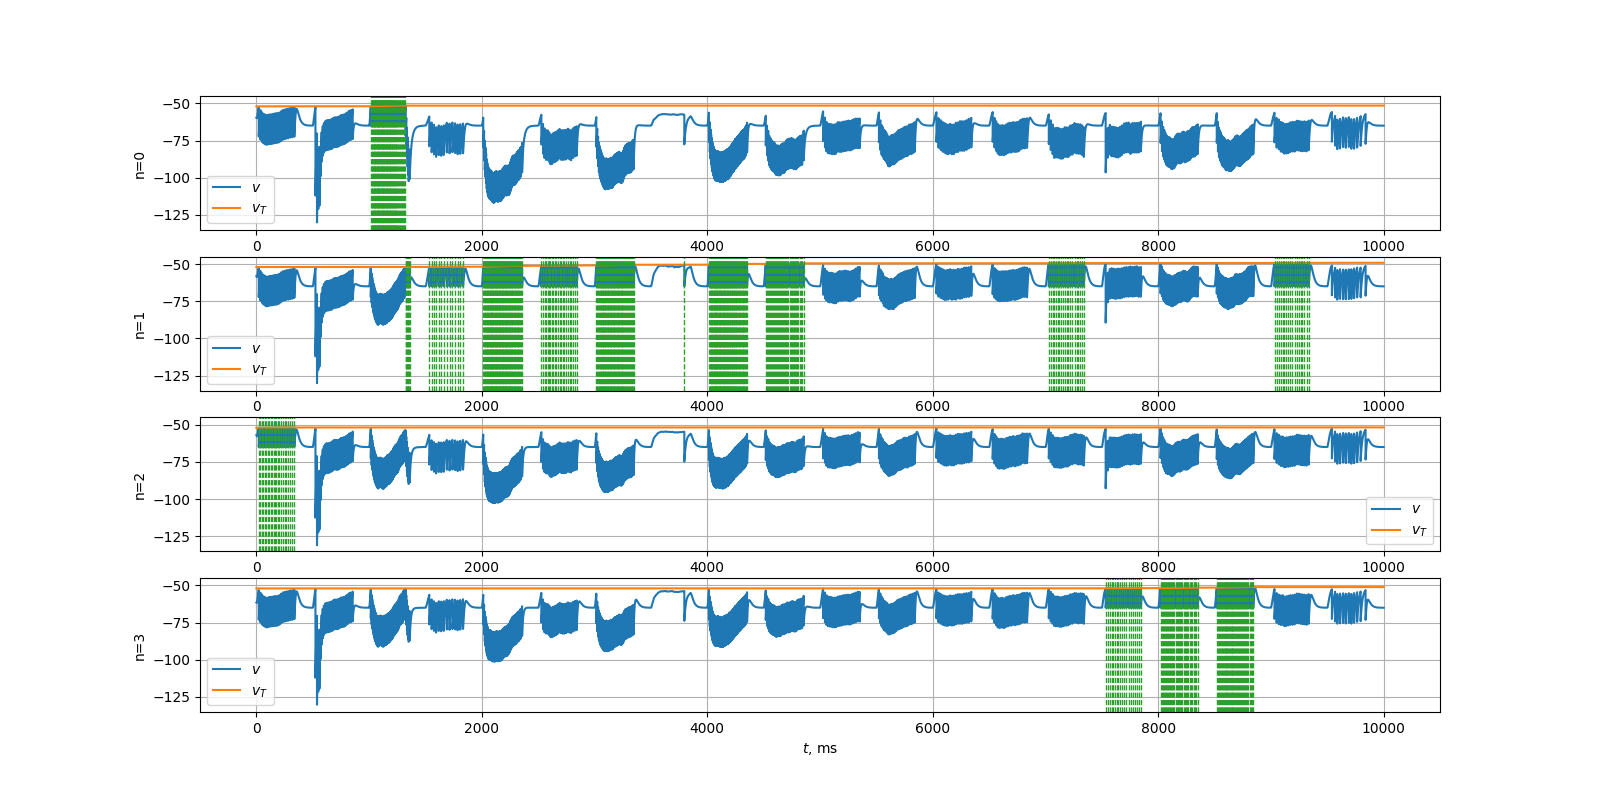

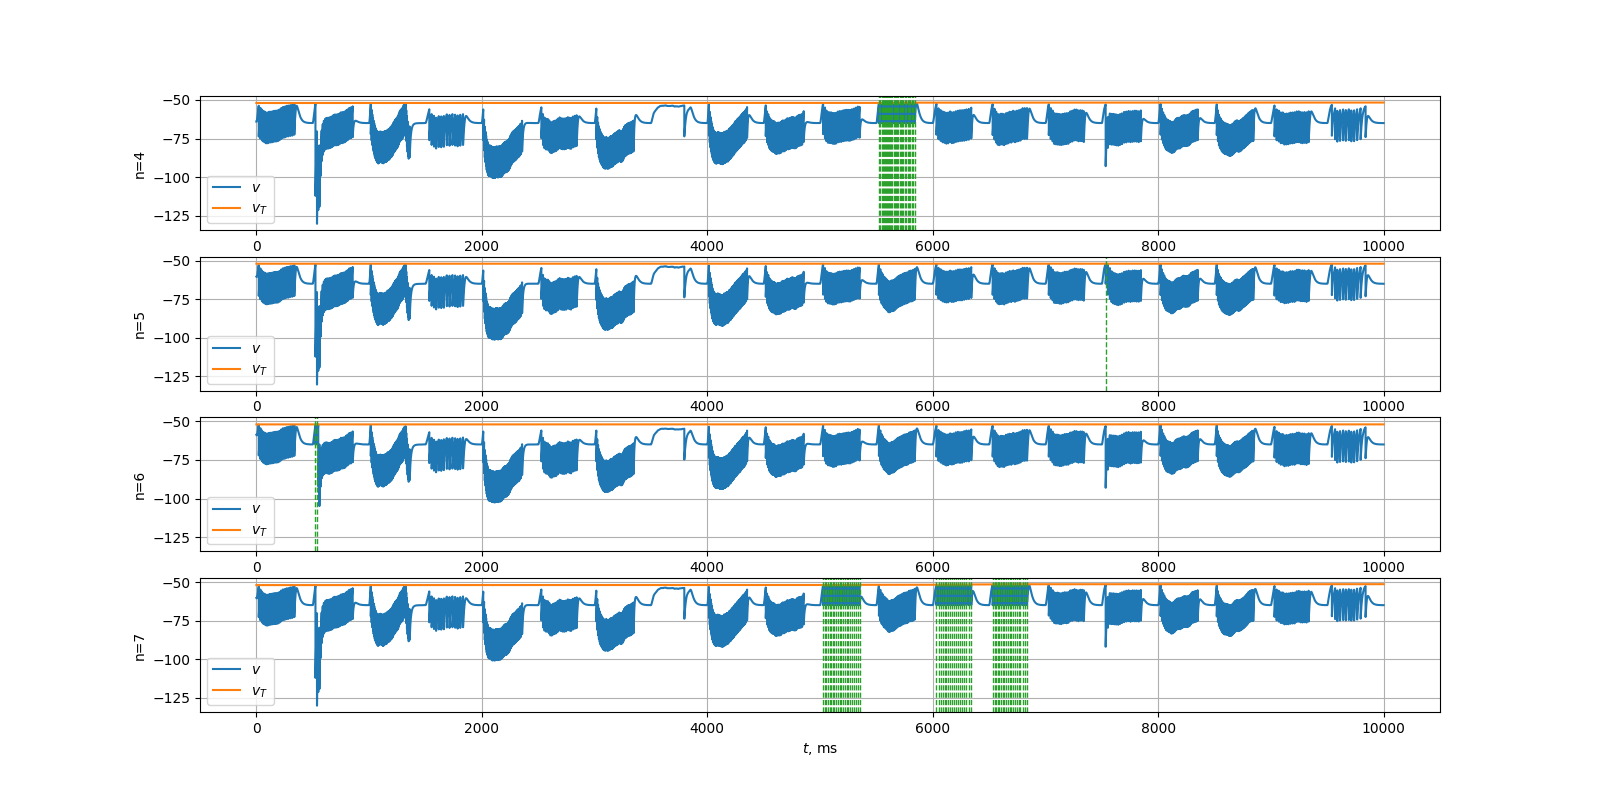

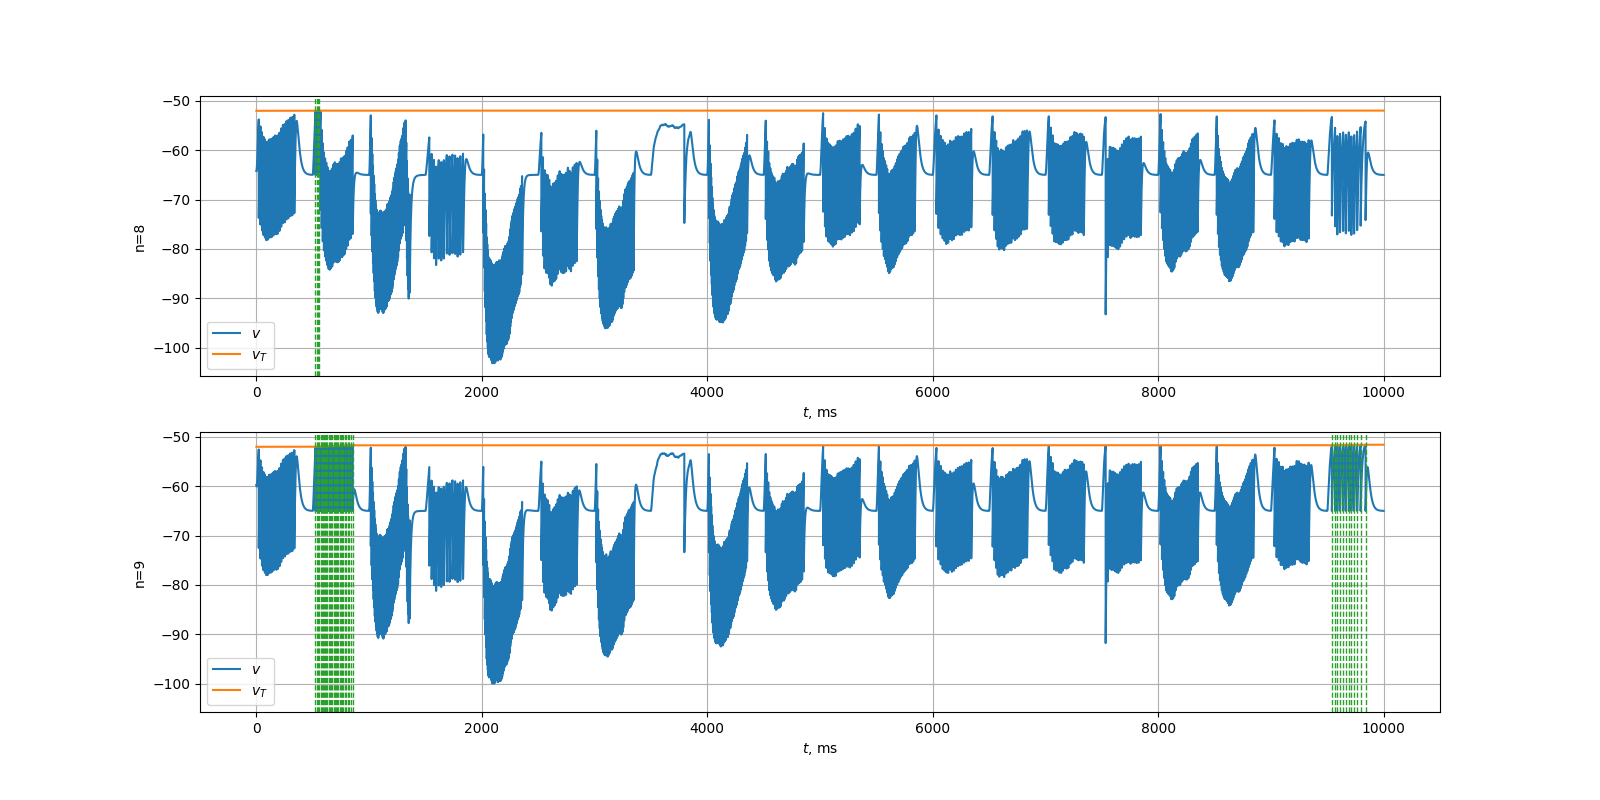

In [18]:
if plot_v_gn:
    i = 0
    for _ in range(2):
        ind_input = [i,i+1,i+2,i+3]
        show_plots_v(e_state_mon, e_spike_mon, ind_input)
        i += 4
    ind_input = [8, 9]
    show_plots_v(e_state_mon, e_spike_mon, ind_input)

In [ ]:
if plot_v_gn:
    ind_input = [0,1,2,3]
    show_plots_gn(e_state_mon, e_spike_mon, ind_input)
    ind_input = [4,5,6,7]
    show_plots_gn(e_state_mon, e_spike_mon, ind_input)

In [ ]:
ind_input = 4
ind_s = [9+round(np.sqrt(ni)*1), 12+round(np.sqrt(ni)*9)]
show_plots_w(i_spike_mon, e_spike_mon, s_state_mon, ind_input, ind_s)

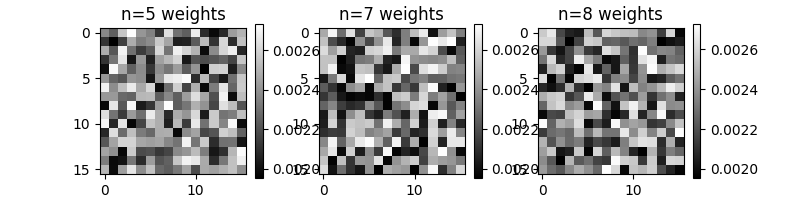

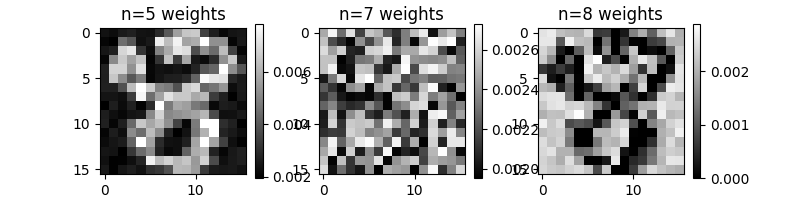

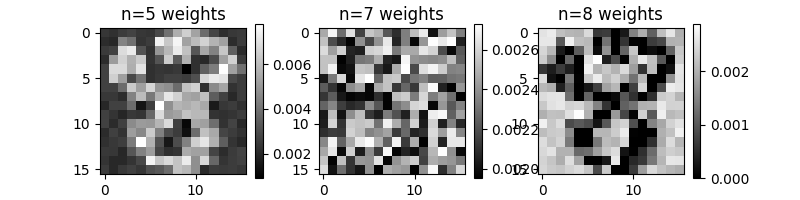

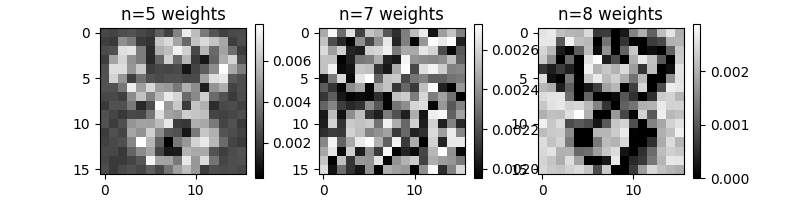

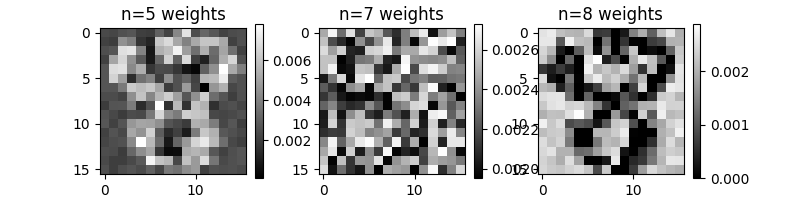

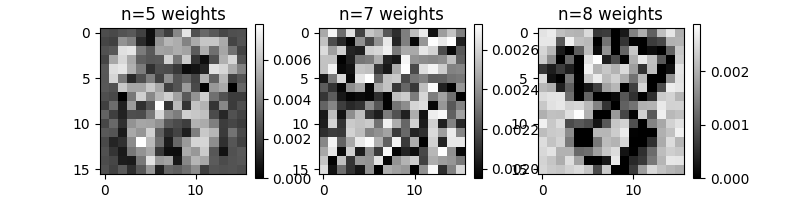

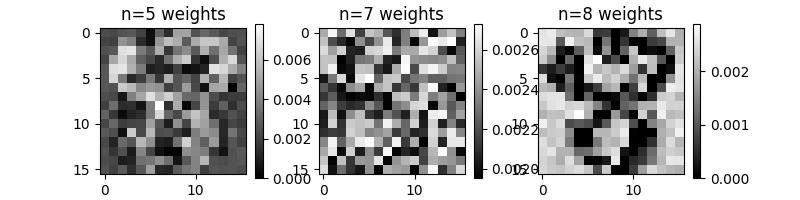

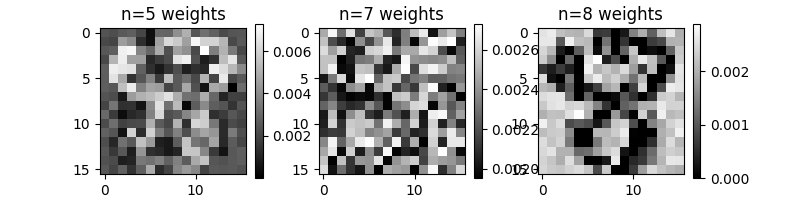

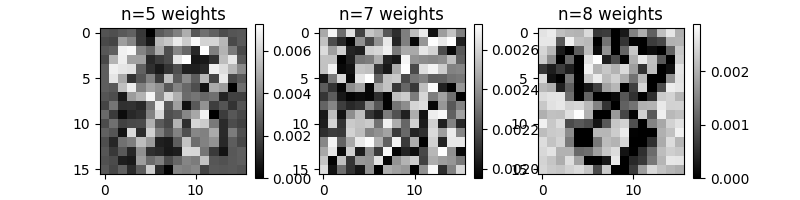

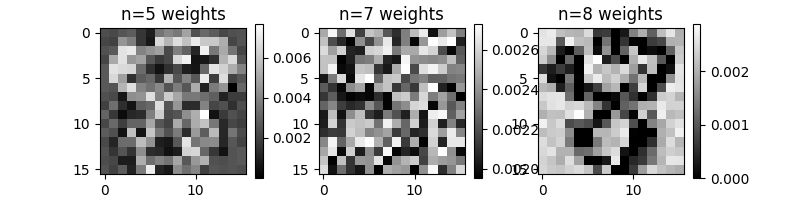

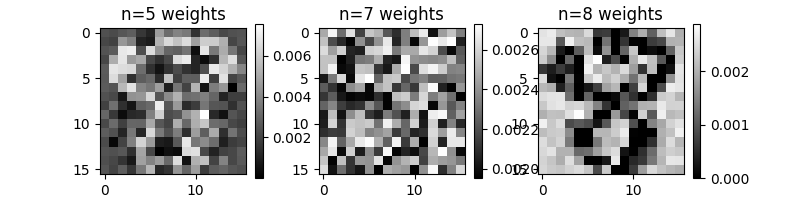

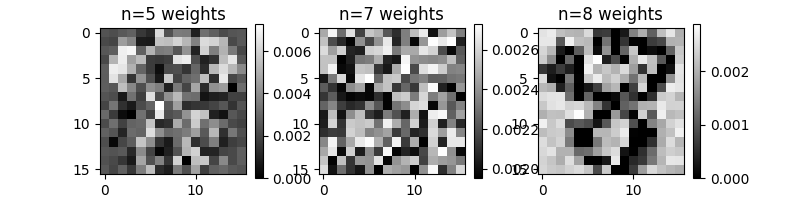

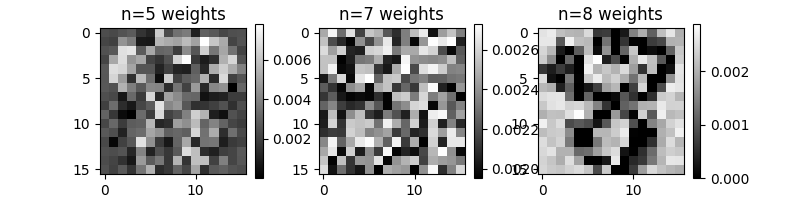

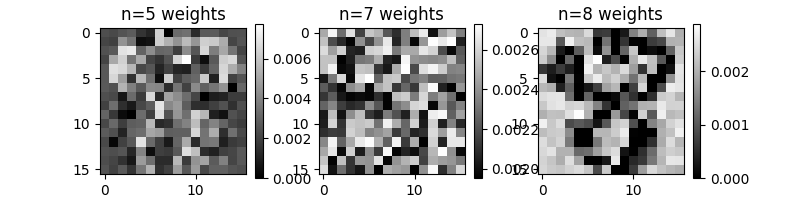

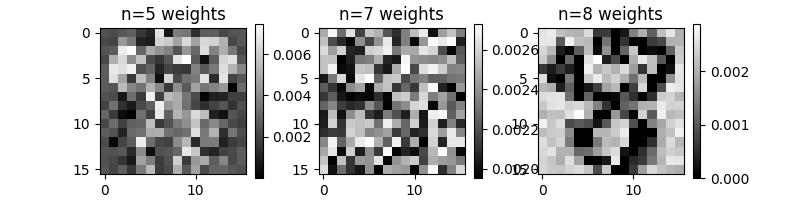

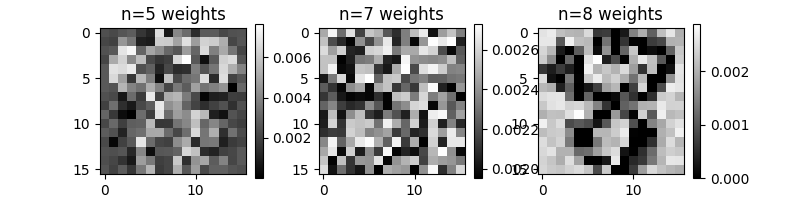

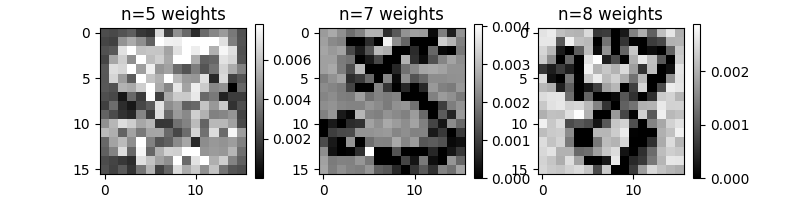

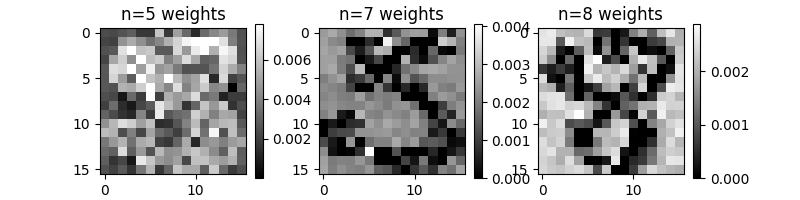

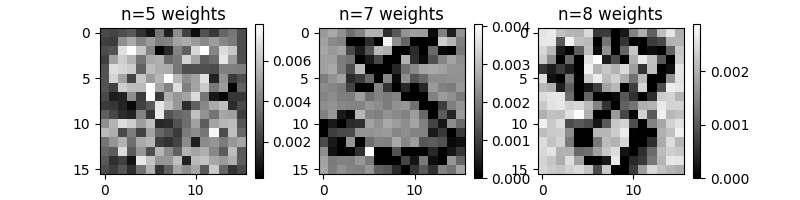

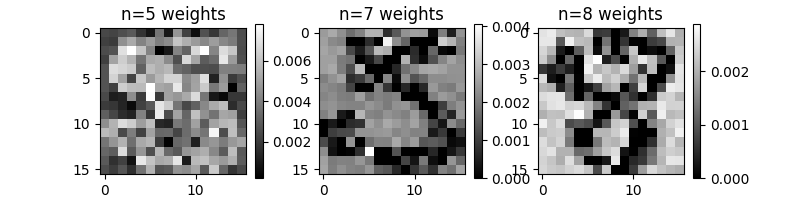

In [ ]:
if remember_current_w:
    ind_input = [5, 7, 8]
    step_range = np.arange(0,20)
    plot_steps_w(current_w, ind_input, step_range)

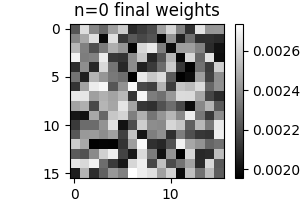

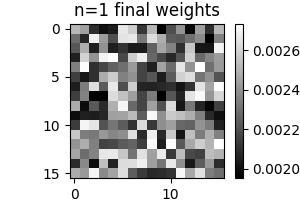

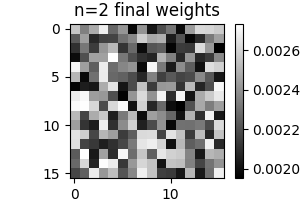

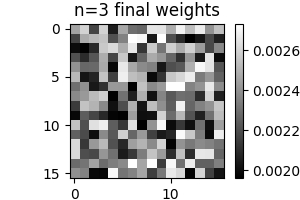

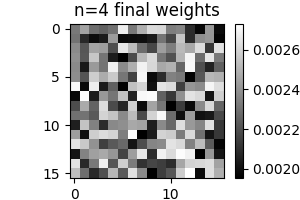

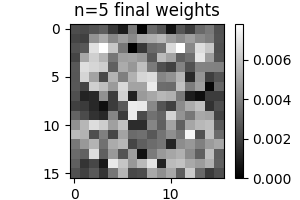

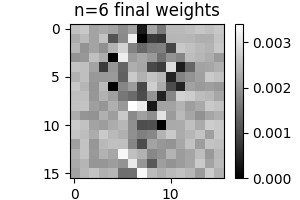

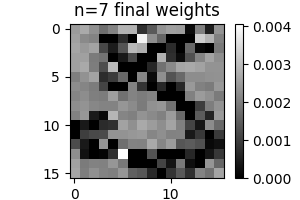

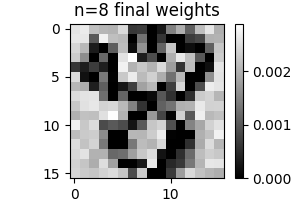

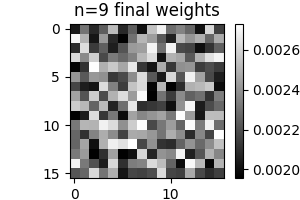

In [ ]:
final_w = np.array((snn.synapses_e.w)).reshape(ni, nn).transpose()
plot_final_w(final_w)

Specific images

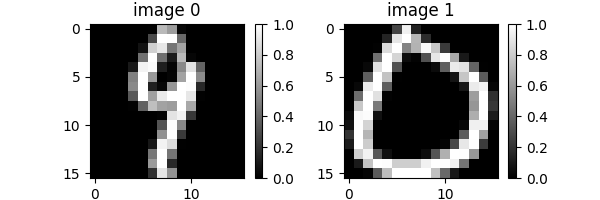

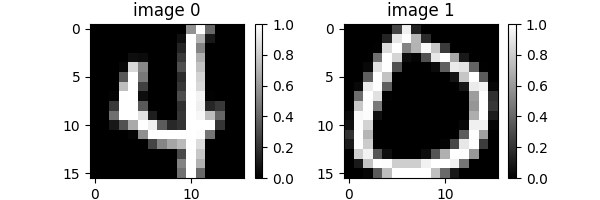

In [ ]:
plt.figure(figsize = (6, 2))
plt.subplot(1,2,1)
plt.imshow(train_images[0].reshape(16,16), cmap='gray')
plt.title("image 0")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(train_images[5].reshape(16,16), cmap='gray')
plt.title("image 1")
plt.colorbar()

plt.figure(figsize = (6, 2))
plt.subplot(1,2,1)
plt.imshow(train_images[1].reshape(16,16), cmap='gray')
plt.title("image 0")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(train_images[7].reshape(16,16), cmap='gray')
plt.title("image 1")
plt.colorbar()

### Results

Classification

In [ ]:
use_best_final_w = True

if use_best_final_w:
    with open(file_path_weights, 'rb') as f:
        w_final = np.load(f)
else: 
    w_final = snn.synapses_e.w

snn = SNN(nn, ni, v_initial, w_final, 0)

classes = CreateClasses(snn, train_rates, train_labels, plot = False)

values = classes.values()
counter = Counter(values)

print("Number of neurons, responsible for the corresponding image: ", dict(counter))

# for k, v in classes.items():
#     if v == '1':
#         print(f"The order of neuron reacting to the image {v}: ", k)

Sample done: 0 / 200
Sample done: 10 / 200
Sample done: 20 / 200
Sample done: 30 / 200
Sample done: 40 / 200
Sample done: 50 / 200
Sample done: 60 / 200
Sample done: 70 / 200
Sample done: 80 / 200
Sample done: 90 / 200
Sample done: 100 / 200
Sample done: 110 / 200
Sample done: 120 / 200
Sample done: 130 / 200
Sample done: 140 / 200
Sample done: 150 / 200
Sample done: 160 / 200
Sample done: 170 / 200
Sample done: 180 / 200
Sample done: 190 / 200
{0: 'None', 1: 'None', 2: 'None', 3: 'None', 4: 'None', 5: 'None', 6: 'None', 7: 'None', 8: 'None', 9: 'None', 10: 'None', 11: 'None', 12: 'None', 13: 'None', 14: 'None', 15: 'None', 16: 'None', 17: 'None', 18: 'None', 19: 'None', 20: 'None', 21: 'None', 22: 'None', 23: 'None', 24: 'None', 25: 'None', 26: 'None', 27: 'None', 28: 'None', 29: 'None', 30: 'None', 31: 'None', 32: 'None', 33: 'None', 34: 'None', 35: 'None', 36: 'None', 37: '0', 38: 'None', 39: 'None'}
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.  

Training accuracy

Sample done: 0 / 200
Sample done: 10 / 200
Sample done: 20 / 200
Sample done: 30 / 200
Sample done: 40 / 200
Sample done: 50 / 200
Sample done: 60 / 200
Sample done: 70 / 200
Sample done: 80 / 200
Sample done: 90 / 200
Sample done: 100 / 200
Sample done: 110 / 200
Sample done: 120 / 200
Sample done: 130 / 200
Sample done: 140 / 200
Sample done: 150 / 200
Sample done: 160 / 200
Sample done: 170 / 200
Sample done: 180 / 200
Sample done: 190 / 200
Precision:  0.1
Recall:  0.1
F1_score:  0.10000000000000002


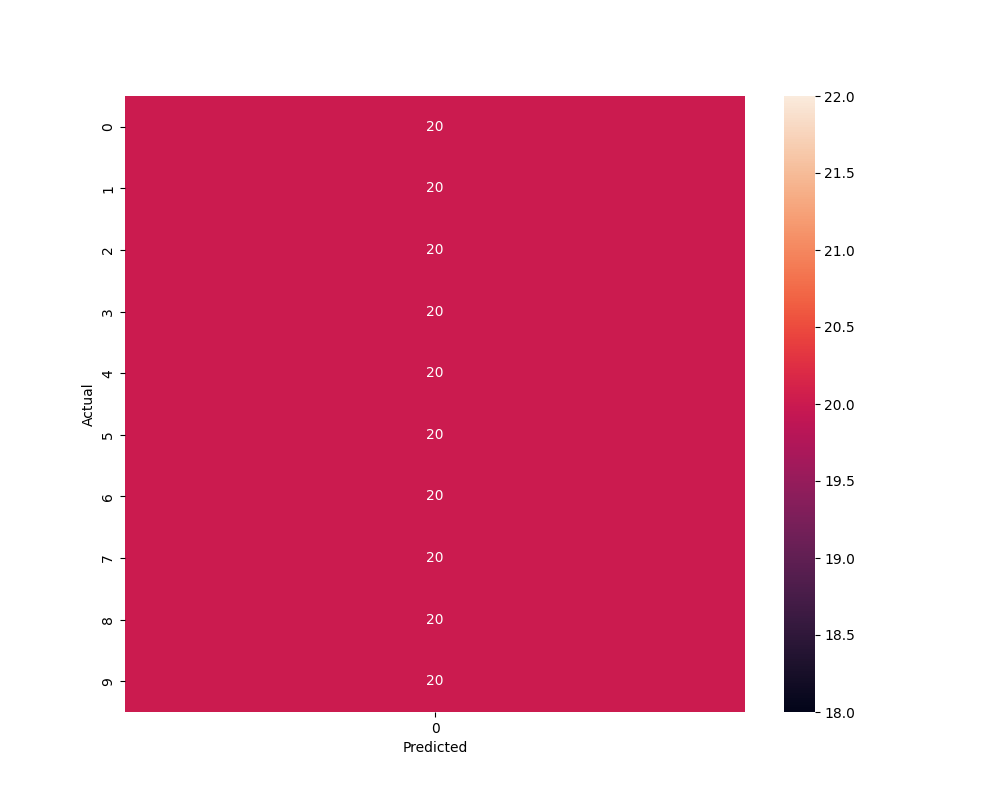

In [ ]:
if use_best_final_w:
    with open(file_path_weights, 'rb') as f:
        w_final = np.load(f)
else: 
    w_final = snn.synapses_e.w

snn = SNN(nn, ni, v_initial, w_final, 0)

pred_train = predict(snn, train_rates, classes, plot = False)
show_confusion_matrix(pred_train, train_labels)
# show_wrong_pics(pred, train_labels, train_images)

train_labels_str = [str(label) for label in train_labels]
precision, recall, F1_score = analyse(pred_train, train_labels_str)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) 

Testing accuracy

Sample done: 0 / 200
Sample done: 10 / 200
Sample done: 20 / 200
Sample done: 30 / 200
Sample done: 40 / 200
Sample done: 50 / 200
Sample done: 60 / 200
Sample done: 70 / 200
Sample done: 80 / 200
Sample done: 90 / 200
Sample done: 100 / 200
Sample done: 110 / 200
Sample done: 120 / 200
Sample done: 130 / 200
Sample done: 140 / 200
Sample done: 150 / 200
Sample done: 160 / 200
Sample done: 170 / 200
Sample done: 180 / 200
Sample done: 190 / 200
Precision:  0.1
Recall:  0.1
F1_score:  0.10000000000000002


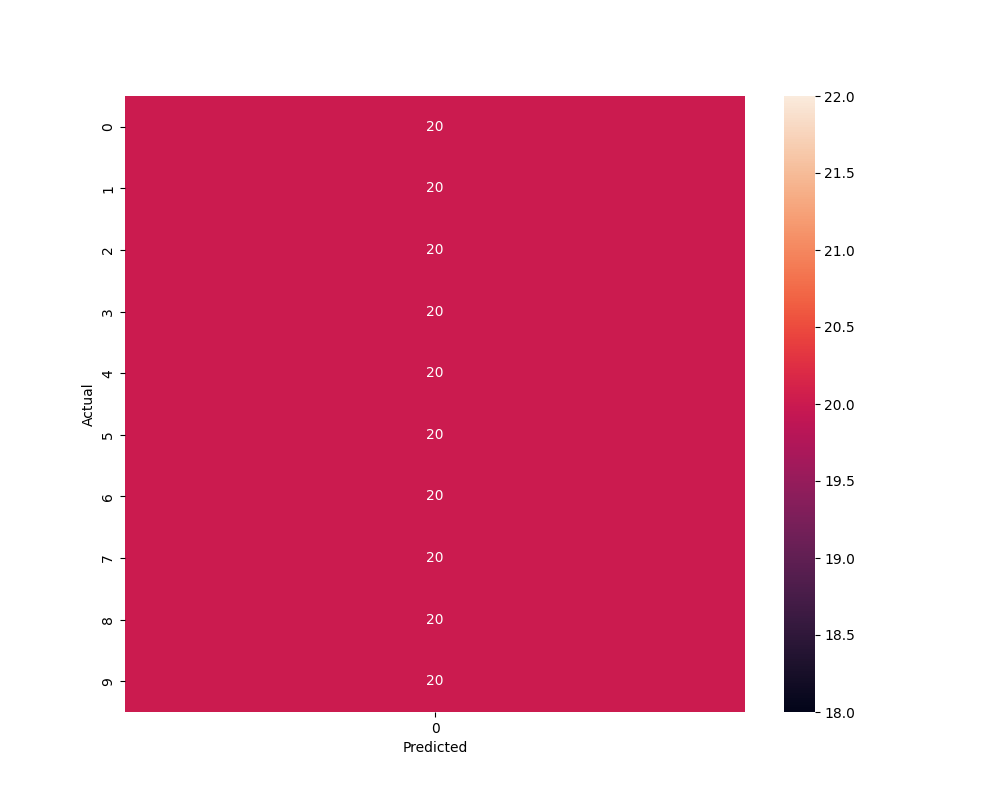

In [ ]:
if use_best_final_w:
    with open(file_path_weights, 'rb') as f:
        w_final = np.load(f)
else: 
    w_final = snn.synapses_e.w

pred_test = predict(snn, test_rates, classes, plot = False)
show_confusion_matrix(pred_test, test_labels)
# show_wrong_pics(pred, test_labels, test_images)

test_labels_str = [str(label) for label in test_labels]
precision, recall, F1_score = analyse(pred_test, test_labels_str)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) 